In [55]:
"""
Train and test minimal predictive processing model to reproduce LZ and TE changes in
the depression state. The model consists of a Kalman filter trained on time series 
from the healthy subjects of the depressed dataset, and depression is modelled as 
a change in the prior and likelihood variance.

Pedro Mediano, Hardik Rajpal, Luka Dubravica, Modified July 2025
"""

from lz76.lz76 import LZ76
from pykalman import KalmanFilter
from pyNuMIT.SS.CSER import StateSpaceEntropyRate
from scipy.signal import butter, filtfilt
from tqdm import tqdm

import h5py
import jpype
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns

project_root = os.getcwd()

In [3]:
def startJVM():
    """
    Start JVM using jpype, if not already running. Assumes the JIDT jar is in
    the current folder.
    """
    jarLocation = os.path.join(project_root, "infodynamics-dist-1.6.1", "infodynamics.jar")
    if not jpype.isJVMStarted():
        jpype.startJVM(jpype.getDefaultJVMPath(), "-ea","-Xmx1024m", "-Djava.class.path=" + jarLocation)


def TE(src, tgt, k=1, tau=1):
    """
    Computes transfer entropy using the JIDT Gaussian solver between two 1D
    time series.
    """
    startJVM()
    te_calc = jpype.JPackage("infodynamics.measures.continuous.gaussian").TransferEntropyCalculatorMultiVariateGaussian()
    te_calc.setProperty("DELAY",str(tau))
    te_calc.setProperty("K",str(k))
    te_calc.setProperty("L",str(k))
    te_calc.initialise(1, 1)
    te_calc.setObservations(src.tolist(), tgt.tolist())
    te_val = te_calc.computeAverageLocalOfObservations()
    return te_val


def simulate(x, f):
    """
    Given a KalmanFilter f and an input time series x, returns a tuple (s,o)
    where s are the filtered states and o are the model prediction errors.
    """
    s = f.filter(x)[0]
    o = (f.observation_matrices @ s.T).T 
    o = np.array(o)
    return (s.squeeze()[1:], o.squeeze()[1:] - x[1:])


def LZ(x):
    """
    Convenience wrapper function to compute normalised LZ of a time series
    after detrending and binarisation.
    """
    return LZ76(1*((x-np.mean(x)) > 0))*np.log(len(x))/len(x)


def copy_filter(kf, prior_factor=1, likelihood_factor=1):
    f = KalmanFilter(n_dim_state=kf.n_dim_state, n_dim_obs=kf.n_dim_obs,
                     initial_state_mean=kf.initial_state_mean,
                     initial_state_covariance = prior_factor*kf.initial_state_covariance,
                     transition_covariance = prior_factor*kf.transition_covariance,
                     observation_covariance = likelihood_factor*kf.observation_covariance,
                     em_vars = ['transition_matrices','observation_matrices'])
    return f


def butter_bandpass(lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=1, axis=0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis)
    return y


def load_subject_calcarine(eeg_source, sub_id, random_trials=True):
    '''
    Loads data from primary visual cortex (calcarine) for a given subject from the loaded MatLab dictionary.
    Data is of the shape (Time x AAL x Trials), where AAL is the number of AAL regions (24 for left calcarine, 25 for right calcarine).
    The function returns a numpy array of shape (Trials x Time) for the calcarine region.
    If random_trials is True, it randomly selects 10 trials from the available data.

    Parameters:
    - eeg_source: dict, loaded MatLab dictionary containing all subjects' data
    - sub_id: str, subject ID to extract data for
    - random_trials: bool, whether to select random trials or not
    Returns:
    - np.ndarray: shape (Trials x Time) for the calcarine region
    '''
    calcarine_idx = 24  # Index for the left calcarine region in AAL atlas (24 for left, 25 for right)
    normalise = lambda x: x/x.std()
    
    # Extract subject data: [samples * sources * trials]
    subject_data = eeg_source[sub_id]
    # Extract calcarine region data and transpose to [trials * samples]
    calcarine_data = subject_data[:, calcarine_idx, :].T
    
    # Select random trials and process data
    nb_trials = 10
    total_trials = calcarine_data.shape[0]
    
    if random_trials:
        idx = np.random.randint(total_trials, size=min(nb_trials, total_trials))
    else:
        idx = np.arange(min(nb_trials, total_trials))
    
    D = calcarine_data[idx]
    D_proc = []
    for i in range(len(D)): #Bandpass filtering for the data. Comment this out if data is already filtered
        filtered_data = butter_bandpass_filter(D[i,:], lowcut=1, highcut=100, fs=600, order=3)
        D_proc.append(normalise(filtered_data))
    
    return np.array(D_proc)  # Returns the processed data as a numpy array of shape (Trials x Time) for a given subject

In [47]:
def model_run(eeg_source_data, subject_ids):
    df = []
    fs = 500 # Sampling frequency of the EEG data
    
    # Loop over each subject
    for z, sub_id in enumerate(tqdm(subject_ids)):
        # print(f"{z+1}/{len(subject_ids)}")
        
        # Loads filtered and normalised data of V1 calcarine region for the subject of shape (Trials x Time)
        D = load_subject_calcarine(eeg_source_data, sub_id, random_trials=True)
        
        ## Train baseline filter
        kf = KalmanFilter()
        for X in D:
            kf.em(X, n_iter=1)

        # Second round of training of baseline filter
        kf2 = copy_filter(kf)
        for X in D:
            kf2.em(X, n_iter=1)

        # Simulate predictions
        sim = [simulate(x, kf2) for x in D] # Get predicted states (frontal regions signal) and prediction errors (sensory regions signal)
        baseline_lz = np.mean([LZ(s[1]) for s in sim]) # LZ estimated for prediction errors

        # print(sim)
        # print(sim[0][1])
        baseline_cser = np.mean(StateSpaceEntropyRate(np.array([s[1] for s in sim]), fs)) # CSER estimated for prediction errors
        
        # baseline_te = np.mean([TE(s[0], s[1], k=1) for s in sim]) # TE estimated from filtered states to prediction errors - front-to-back / top-down
        baseline_te = np.mean([TE(s[1], s[0], k=1) for s in sim]) # TE estimated from prediction errors to filtered states - back-to-front / bottom-up

        factor_vec = 2.0**np.arange(-5,6,1)
        
        for eta in factor_vec:
            # print(np.round(eta,2),end="...")

            # Try different prior and likelihood factors to match the LZ and TE changes in the Depressed condition.
            # Train one filter and then copy it with different prior/likelihood factors.
        
            ## Define model filter for depression
            prior_kf = copy_filter(kf, prior_factor=eta)
            likelihood_kf = copy_filter(kf, likelihood_factor=eta)
            # prior_factor=eta - increases prior variance - mimics overactive top-down priors
            # likelihood_factor=eta - increases likelihood variance - mimics overactive sensory trust (or weakened frontal control)

            ## Retrain the model with the same data, but with different prior/likelihood factors
            for X in D:
                prior_kf.em(X, n_iter=1)
                likelihood_kf.em(X, n_iter=1)
        
            ## Simulate and compute LZ+TE
            for t, x in enumerate(D):
                prior_sim = simulate(x, prior_kf)
                prior_lz = LZ(prior_sim[1])
                prior_cser = StateSpaceEntropyRate(np.array([prior_sim[1]]), fs)
                # te = TE(prior_sim[0], prior_sim[1], k=1) # front-to-back / top-down
                prior_te = TE(prior_sim[1], prior_sim[0], k=1) # back-to-front / bottom-up
                df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Factor': eta,
                                        'Trial': t, 'LZ': prior_lz, 'TE': prior_te, 'CSER': prior_cser,
                                        'Model': 'Prior'}, index=[0]))
                
                likelihood_sim = simulate(x, likelihood_kf)
                likelihood_lz = LZ(likelihood_sim[1])
                likelihood_cser = StateSpaceEntropyRate(np.array([likelihood_sim[1]]), fs)
                # te = TE(likelihood_sim[0], likelihood_sim[1], k=1) # front-to-back / top-down
                likelihood_te = TE(likelihood_sim[1], likelihood_sim[0], k=1) # back-to-front / bottom-up
                df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Factor': eta,
                                        'Trial': t, 'LZ': likelihood_lz, 'TE': likelihood_te, 'CSER': likelihood_cser,
                                        'Model': 'Likelihood'}, index=[0]))
        
                # Add baseline again, for convenience
                df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Factor': eta, 'Trial': t, 
                                        'LZ': baseline_lz, 'TE': baseline_te, 'CSER': baseline_cser, 
                                        'Model': 'Baseline'}, index=[0]))
    
    return pd.concat(df, ignore_index=True)

In [97]:
def model_run_baseline(eeg_source_data, subject_ids):
    df = []
    fs = 500 # Sampling frequency of the EEG data
    
    # Loop over each subject
    for z, sub_id in enumerate(tqdm(subject_ids)):
        # print(f"{z+1}/{len(subject_ids)}")
        
        # Loads filtered and normalised data of V1 calcarine region for the subject of shape (Trials x Time)
        D = load_subject_calcarine(eeg_source_data, sub_id, random_trials=True)
        
        ## Train baseline filter
        kf = KalmanFilter()
        for X in D:
            kf.em(X, n_iter=1)

        # Second round of training of baseline filter
        kf2 = copy_filter(kf)
        for X in D:
            kf2.em(X, n_iter=1)

        # Simulate predictions
        sim = [simulate(x, kf2) for x in D] # Get predicted states (frontal regions signal) and prediction errors (sensory regions signal)
        baseline_lz = np.mean([LZ(s[1]) for s in sim]) # LZ estimated for prediction errors
        baseline_cser = np.mean(StateSpaceEntropyRate(np.array([s[1] for s in sim]), fs)) # CSER estimated for prediction errors
        baseline_te = np.mean([TE(s[1], s[0], k=1) for s in sim]) # TE estimated from prediction errors to filtered states - back-to-front / bottom-up
        
                # Add baseline again, for convenience
        df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Factor': 'x', 'Trial': 'x', 
                                'LZ': baseline_lz, 'TE': baseline_te, 'CSER': baseline_cser, 
                                'Model': 'Baseline'}, index=[0]))
    
    return pd.concat(df, ignore_index=True)

In [75]:
def model_run_double(eeg_source_data, subject_ids):
    df = []
    fs = 500 # Sampling frequency of the EEG data
    
    # Loop over each subject
    for z, sub_id in enumerate(tqdm(subject_ids)):
        # print(f"{z+1}/{len(subject_ids)}")
        
        # Loads filtered and normalised data of V1 calcarine region for the subject of shape (Trials x Time)
        D = load_subject_calcarine(eeg_source_data, sub_id, random_trials=True)
        
        ## Train baseline filter
        kf = KalmanFilter()
        for X in D:
            kf.em(X, n_iter=1)

        # Second round of training of baseline filter
        kf2 = copy_filter(kf)
        for X in D:
            kf2.em(X, n_iter=1)

        # Simulate predictions
        sim = [simulate(x, kf2) for x in D] # Get predicted states (frontal regions signal) and prediction errors (sensory regions signal)
        
        baseline_lz = np.mean([LZ(s[1]) for s in sim]) # LZ estimated for prediction errors
        baseline_cser = np.mean(StateSpaceEntropyRate(np.array([s[1] for s in sim]), fs)) # CSER estimated for prediction errors
    
        # baseline_te = np.mean([TE(s[0], s[1], k=1) for s in sim]) # TE estimated from filtered states to prediction errors - front-to-back / top-down
        baseline_te = np.mean([TE(s[1], s[0], k=1) for s in sim]) # TE estimated from prediction errors to filtered states - back-to-front / bottom-up

        factor_vec = 2.0**np.arange(-5,6,1)
        
        for prior_eta in factor_vec:
            for likelihood_eta in factor_vec:

                depress_kf = copy_filter(kf, prior_factor=prior_eta, likelihood_factor=likelihood_eta)

                ## Retrain the model with the same data, but with different prior/likelihood factors
                for X in D:
                    depress_kf.em(X, n_iter=1)
            
                ## Simulate and compute LZ+TE
                for t, x in enumerate(D):
                    depress_sim = simulate(x, depress_kf)
                    depress_lz = LZ(depress_sim[1])
                    depress_cser = StateSpaceEntropyRate(np.array([depress_sim[1]]), fs)
                    depress_te = TE(depress_sim[1], depress_sim[0], k=1) # back-to-front / bottom-up
                    df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Prior Factor': prior_eta, 'Likelihood Factor': likelihood_eta,
                                            'Trial': t, 'LZ': depress_lz, 'TE': depress_te, 'CSER': depress_cser, 'Model': 'Depression'}, index=[0]))
            
                    # Add baseline again, for convenience
                    df.append(pd.DataFrame({'Subject': sub_id, 'Dataset': 'EEG', 'Prior Factor': prior_eta, 'Likelihood Factor': likelihood_eta,
                                            'Trial': t, 'LZ': baseline_lz, 'TE': baseline_te, 'CSER': baseline_cser, 'Model': 'Baseline'}, index=[0]))
    
    return pd.concat(df, ignore_index=True)

In [98]:
print("Loading excel and matlab data...")

# Read the Excel file
file_name = 'Data_4_Import_REST.xlsx'
excel_sheet_name = 'Depression Rest'
file_path = os.path.join("Depression_Study", "depression_data", file_name)
df_excel = pd.read_excel(file_path, sheet_name=excel_sheet_name)
# df_excel['depressed'] = df_excel['MDD'].apply(lambda x: 1 if x <= 2 else 0)
df_excel['depressed'] = df_excel['BDI'].apply(lambda x: 1 if x >= 13 else 0)

# Load all subjects' source reconstructed data from a matlab file
data_file = os.path.join(project_root, 'eeg_source.mat')
eeg_source = h5py.File(data_file, 'r')
eeg_source_open = eeg_source[f'eeg_source_open']
eeg_source_closed = eeg_source[f'eeg_source_closed']

# Get all subject IDs from the struct fields
healthy_subjects = df_excel[df_excel['depressed'] == 0]['id'].astype(str).values
subject_ids = [key for key in eeg_source_open.keys() if key[1:] in healthy_subjects]

subject_ids = random.sample(subject_ids, 10) # TESTING
print(f"Selected {len(subject_ids)} subjects for testing: " + ', '.join(subject_ids))

# Remove bad subject data
subject_ids = [sub_id for sub_id in subject_ids if sub_id not in ['x527', 'x535']]

# Run the model
print(f"Running open eyes model for {len(subject_ids)} subjects")
df_bdi_open = model_run(eeg_source_open, subject_ids)
print(f"Running closed eyes model for {len(subject_ids)} subjects")
df_bdi_closed = model_run(eeg_source_closed, subject_ids)

################ DEPRESSED BASELINE BDI ################

# Get depressed subjects
depressed_subjects = df_excel[df_excel['depressed'] == 1]['id'].astype(str).values
subject_ids = [key for key in eeg_source_open.keys() if key[1:] in healthy_subjects]

subject_ids = random.sample(subject_ids, 10) # TESTING
print(f"Selected {len(subject_ids)} subjects for testing: " + ', '.join(subject_ids))

# Remove bad subject data
subject_ids = [sub_id for sub_id in subject_ids if sub_id not in ['x527', 'x535']]

# Run the depressed baseline model
print(f"Running open eyes depressed baseline model for {len(subject_ids)} subjects")
df_bdi_open_depressed_baseline = model_run_baseline(eeg_source_open, subject_ids)
print(f"Running closed eyes depressed baseline model for {len(subject_ids)} subjects")
df_bdi_closed_depressed_baseline = model_run_baseline(eeg_source_closed, subject_ids)

################ DEPRESSED BASELINE MDD ################

df_excel['depressed'] = df_excel['MDD'].apply(lambda x: 1 if x <= 2 else 0)
# Get depressed subjects
depressed_subjects = df_excel[df_excel['depressed'] == 1]['id'].astype(str).values
subject_ids = [key for key in eeg_source_open.keys() if key[1:] in healthy_subjects]

subject_ids = random.sample(subject_ids, 10) # TESTING
print(f"Selected {len(subject_ids)} subjects for testing: " + ', '.join(subject_ids))

# Remove bad subject data
subject_ids = [sub_id for sub_id in subject_ids if sub_id not in ['x527', 'x535']]

# Run the depressed baseline model
print(f"Running open eyes depressed baseline model for {len(subject_ids)} subjects")
df_open_depressed_baseline = model_run_baseline(eeg_source_open, subject_ids)
print(f"Running closed eyes depressed baseline model for {len(subject_ids)} subjects")
df_closed_depressed_baseline = model_run_baseline(eeg_source_closed, subject_ids)


Loading excel and matlab data...
Selected 10 subjects for testing: x537, x519, x585, x509, x513, x552, x588, x596, x599, x575
Running open eyes model for 10 subjects


100%|██████████| 10/10 [45:08<00:00, 270.85s/it]


Running closed eyes model for 10 subjects


100%|██████████| 10/10 [45:13<00:00, 271.37s/it]


Selected 10 subjects for testing: x536, x518, x581, x515, x535, x512, x529, x508, x548, x553
Running open eyes depressed baseline model for 9 subjects


100%|██████████| 9/9 [03:01<00:00, 20.13s/it]


Running closed eyes depressed baseline model for 9 subjects


100%|██████████| 9/9 [02:55<00:00, 19.53s/it]


Selected 10 subjects for testing: x578, x537, x576, x588, x514, x515, x577, x574, x529, x562
Running open eyes depressed baseline model for 10 subjects


100%|██████████| 10/10 [03:14<00:00, 19.44s/it]


Running closed eyes depressed baseline model for 10 subjects


100%|██████████| 10/10 [03:13<00:00, 19.35s/it]


In [77]:
df_open_double_test = df_open_double.copy()
df_closed_double_test = df_closed_double.copy()

# Save the results to pickle files
with open('df_open_double_test.pkl', 'wb') as f:
    pickle.dump(df_open_double_test, f)
with open('df_closed_double_test.pkl', 'wb') as f:
    pickle.dump(df_closed_double_test, f)

In [ ]:
# Load the results from pickle file
df_single_open = None
with open('df_single_open.pkl', 'rb') as f:
    df_single_open = pickle.load(f)

df_single_closed = None
with open('df_single_closed.pkl', 'rb') as f:
    df_single_closed = pickle.load(f)

In [103]:
baseline_od = df_open_depressed_baseline

df_temp = []

factor_vec = 2.0**np.arange(-5,6,1)
        
for eta in factor_vec:
    for t in range(10):
        df_temp.append(pd.DataFrame({'Subject': -1, 'Dataset': 'EEG', 'Factor': eta,
                                     'Trial': t, 'LZ': baseline_od['LZ'], 'TE': baseline_od['TE'], 'CSER': baseline_od['CSER'],
                                     'Model': 'Real'}, index=[0]))

df_open_depressed_baseline = pd.concat(df_temp, ignore_index=True)

#########

# baseline_cd = df_closed_depressed_baseline

# df_temp = []

# factor_vec = 2.0**np.arange(-5,6,1)
        
# for eta in factor_vec:
#     for t in range(10):
#         df_temp.append(pd.DataFrame({'Subject': -1, 'Dataset': 'EEG', 'Factor': eta,
#                                      'Trial': t, 'LZ': baseline_od['LZ'], 'TE': baseline_od['TE'], 'CSER': baseline_od['CSER'],
#                                      'Model': 'Real'}, index=[0]))

# df_closed_depressed_baseline = pd.concat(df_temp, ignore_index=True)

## Data Display

In [99]:
def plot_df(df, eyes):

    # df['Factor'] = df['Prior Factor'].fillna(df['Likelihood Factor'])

    sns.set_theme(style="whitegrid", font_scale=1.2)

    # TOP PLOT

    # Create subplots: one for LZ, one for TE
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

    # Plot LZ vs Factor with error bars
    sns.lineplot(data=df, x='Factor', y='LZ', hue='Model', marker='o', 
                errorbar=('ci', 60), ax=axs[0])
    axs[0].set_title('Lempel-Ziv Complexity vs Factor (η) - eyes ' + eyes)
    axs[0].set_xscale('log', base=2)
    axs[0].set_xlabel('Factor (η)')
    axs[0].set_ylabel('LZ Complexity')

    # Plot CSER vs Factor with error bars
    sns.lineplot(data=df, x='Factor', y='CSER', hue='Model', marker='o', 
                errorbar=('ci', 60), ax=axs[1])
    axs[1].set_title('CSER vs Factor (η) - eyes ' + eyes)
    axs[1].set_xscale('log', base=2)
    axs[1].set_xlabel('Factor (η)')
    axs[1].set_ylabel('CSER')

    # Plot TE vs Factor with error bars
    sns.lineplot(data=df, x='Factor', y='TE', hue='Model', marker='o',
                errorbar=('ci', 60), ax=axs[2])
    axs[2].set_title('Transfer Entropy vs Factor (η) - eyes ' + eyes)
    axs[2].set_xscale('log', base=2)
    axs[2].set_xlabel('Factor (η)')
    axs[2].set_ylabel('Transfer Entropy')

    # Formatting
    for ax in axs:
        ax.legend(title='Model')
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # BOTTOM PLOT

    df_likelihood = df.loc[df['Model'] == 'Likelihood'].loc[df['Factor'] <= 1].copy()
    df_likelihood.loc[:, 'Factor'] = 1 / df_likelihood['Factor'].values
    df_likelihood.loc[:, 'Model'] = 'Likelihood'

    df_prior = df.loc[df['Model'] == 'Prior'].loc[df['Factor'] >= 1].copy()
    df_prior.loc[:, 'Model'] = 'Prior'

    df_base = df.loc[df['Model'] == 'Baseline'].loc[df['Factor'] >= 1].copy()

    df_all = pd.concat([df_likelihood, df_prior, df_base], ignore_index=True)

    # Create subplots: one for LZ, one for TE
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

    # Plot LZ vs Prior Factor with error bars
    sns.lineplot(data=df_all, x='Factor', y='LZ', hue='Model', marker='o', 
                errorbar=('ci', 60), ax=axs[0])
    axs[0].set_title('Lempel-Ziv Complexity vs Factor (η) - eyes ' + eyes)
    axs[0].set_xscale('log', base=2)
    axs[0].set_xlabel('Factor (η) - Prior: η, Likelihood: 1/η')
    axs[0].set_ylabel('LZ Complexity')

    # Plot CSER vs Factor with error bars
    sns.lineplot(data=df_all, x='Factor', y='CSER', hue='Model', marker='o', 
                errorbar=('ci', 60), ax=axs[1])
    axs[1].set_title('CSER vs Factor (η) - eyes ' + eyes)
    axs[1].set_xscale('log', base=2)
    axs[1].set_xlabel('Factor (η) - Prior: η, Likelihood: 1/η')
    axs[1].set_ylabel('CSER')

    # Plot TE vs Prior Factor with error bars
    sns.lineplot(data=df_all, x='Factor', y='TE', hue='Model', marker='o',
                errorbar=('ci', 60), ax=axs[2])
    axs[2].set_title('Transfer Entropy vs Factor (η) - eyes ' + eyes)
    axs[2].set_xscale('log', base=2)
    axs[2].set_xlabel('Factor (η) - Prior: η, Likelihood: 1/η')
    axs[2].set_ylabel('Transfer Entropy')

    # Formatting
    for ax in axs:
        ax.legend(title='Model')
        ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

=== OPEN EYES HEATMAPS ===


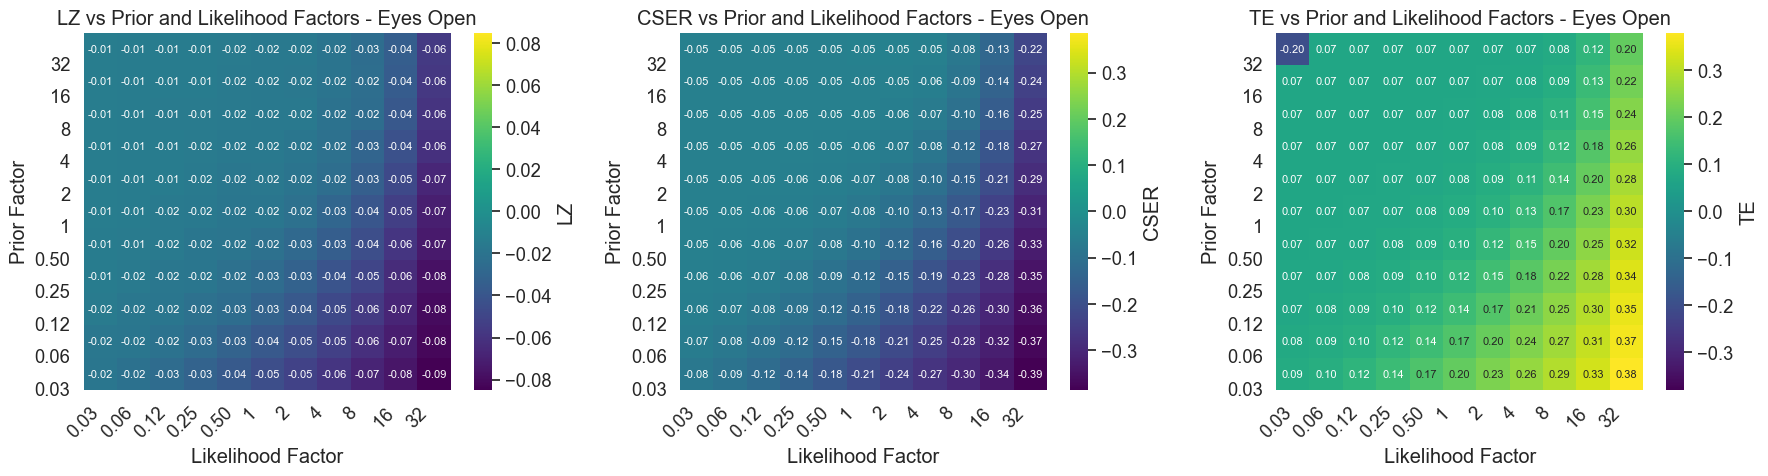

=== CLOSED EYES HEATMAPS ===


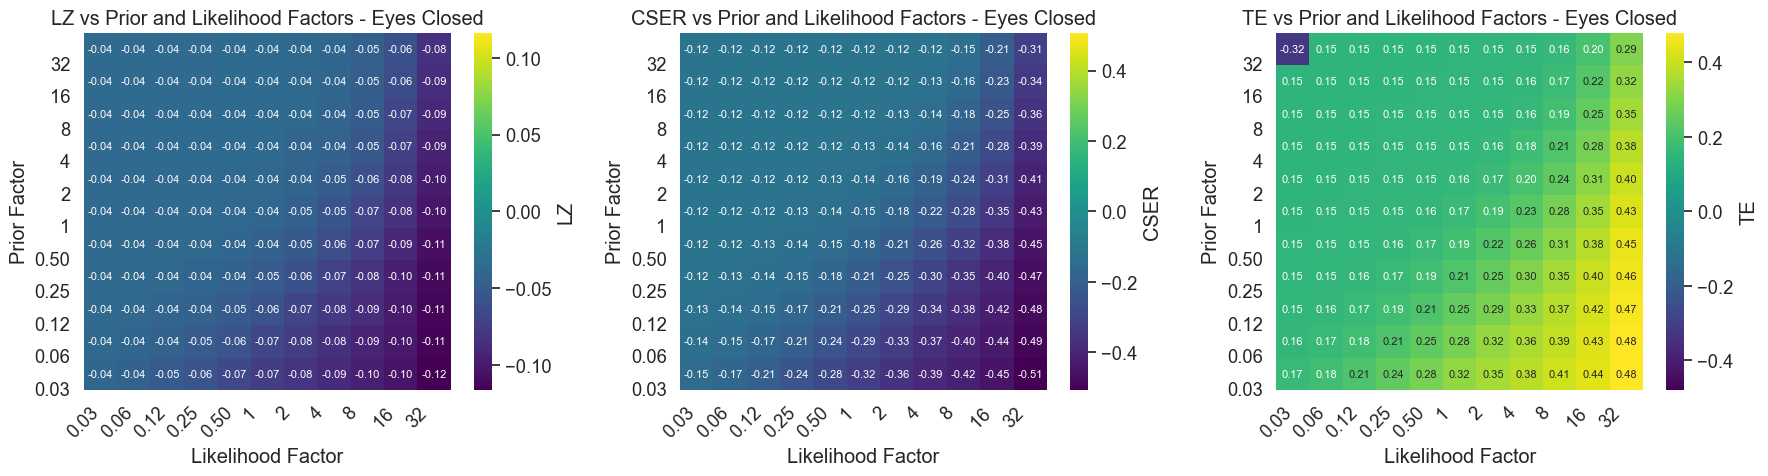

In [93]:
def plot_heatmap_double_factors(df, eyes):
    """
    Plot heatmaps showing the relationship between prior factor, likelihood factor, and the three metrics: LZ, CSER and TE.
    The color bar is symmetric about zero.
    
    Parameters:
    - df: DataFrame with columns 'Prior Factor', 'Likelihood Factor', 'LZ', 'CSER' and 'TE'
    - eyes: string indicating 'open' or 'closed' for the title
    """
    
    # Filter for Depression model only (exclude Baseline)
    df_depression = df[df['Model'] == 'Depression'].copy()
    
    baseline = df[df['Model'] == 'Baseline'].iloc[0]
    df_depression['LZ'] = df_depression['LZ'] - baseline['LZ']
    df_depression['CSER'] = df_depression['CSER'] - baseline['CSER']
    df_depression['TE'] = df_depression['TE'] - baseline['TE']
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Get factor values for consistent labeling
    factor_values = sorted(df_depression['Prior Factor'].unique())

    # Plot each metric
    metrics = ['LZ', 'CSER', 'TE']

    for i, metric in enumerate(metrics):
        # Create pivot table for heatmap
        pivot_data = df_depression.groupby(['Prior Factor', 'Likelihood Factor'])[metric].mean().reset_index()
        heatmap_data = pivot_data.pivot(index='Prior Factor', columns='Likelihood Factor', values=metric)

        # Find symmetric vmin/vmax for colorbar
        vmax = np.nanmax(np.abs(heatmap_data.values))
        vmin = -vmax

        # Create the heatmap
        sns.heatmap(heatmap_data, 
                    annot=True,
                    fmt='.2f',
                    annot_kws={'size': 8},
                    cmap='viridis',
                    cbar_kws={'label': metric},
                    ax=axes[i],
                    vmin=vmin,
                    vmax=vmax)

        axes[i].set_title(f'{metric} vs Prior and Likelihood Factors - Eyes {eyes.capitalize()}')
        axes[i].set_xlabel('Likelihood Factor')
        axes[i].set_ylabel('Prior Factor')

        axes[i].set_xticks(range(len(factor_values)))
        axes[i].set_xticklabels([f'{val:.2f}' if val < 1 else f'{val:.0f}' for val in factor_values], rotation=45)
        axes[i].set_yticks(range(len(factor_values)))
        axes[i].set_yticklabels([f'{val:.2f}' if val < 1 else f'{val:.0f}' for val in factor_values], rotation=0)

        axes[i].invert_yaxis()

    plt.tight_layout()
    plt.show()

# Plot heatmaps for both eye conditions
print("=== OPEN EYES HEATMAPS ===")
plot_heatmap_double_factors(df_open_double, 'open')

print("=== CLOSED EYES HEATMAPS ===")
plot_heatmap_double_factors(df_closed_double, 'closed')

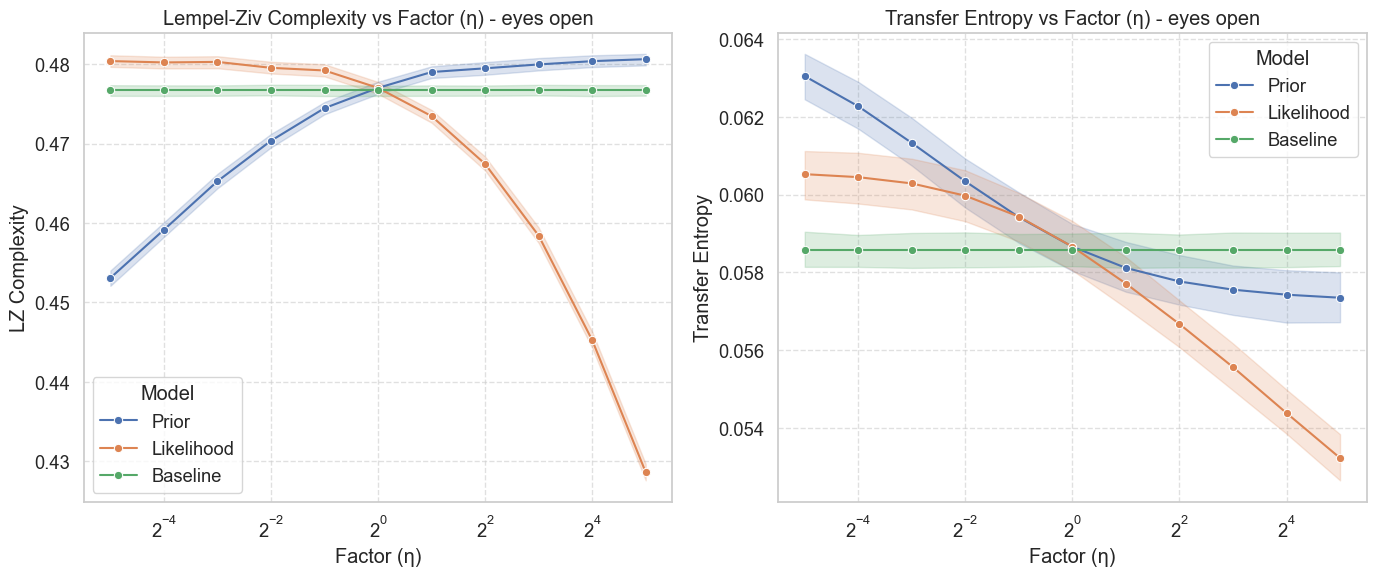

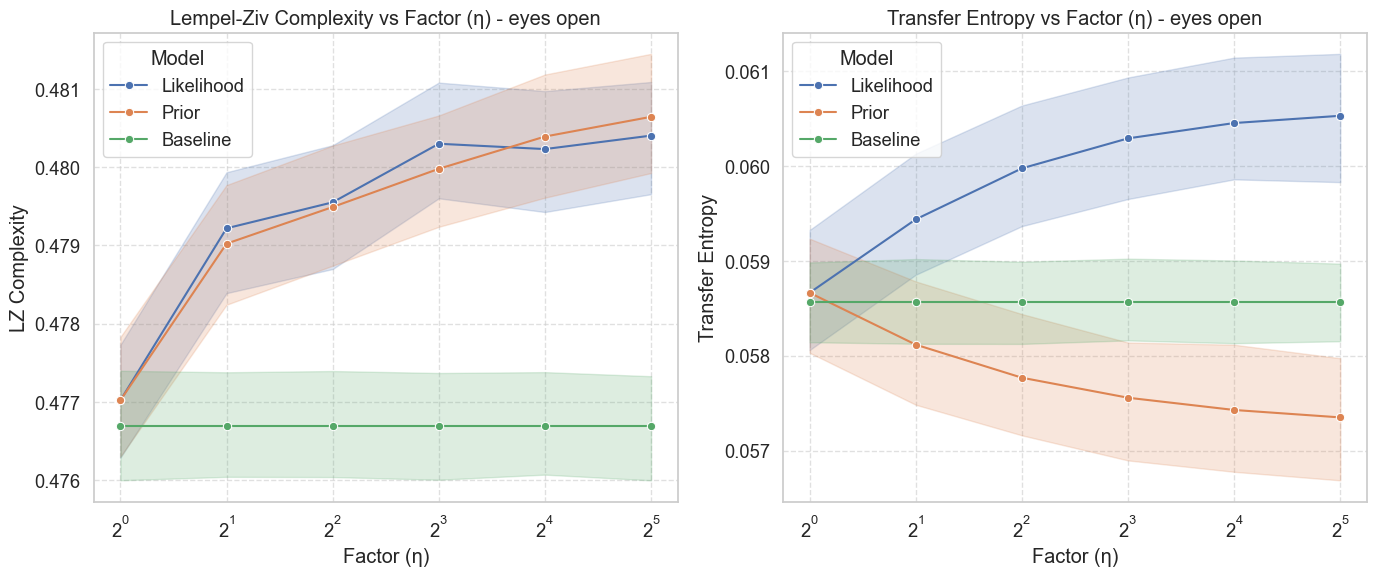

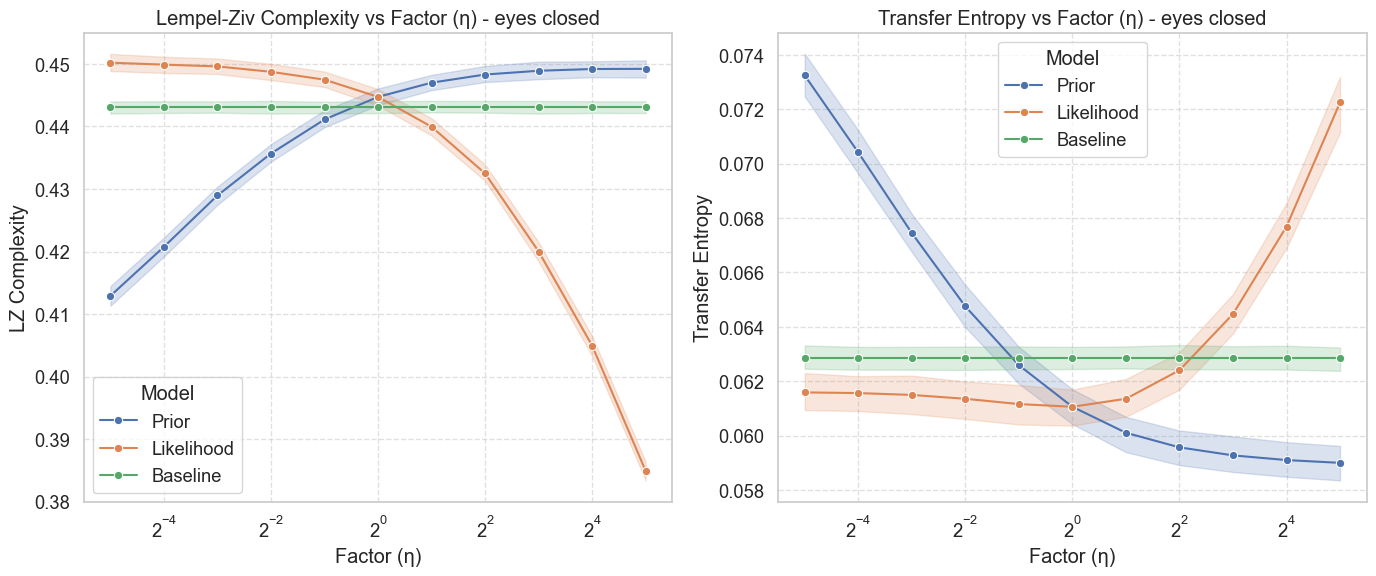

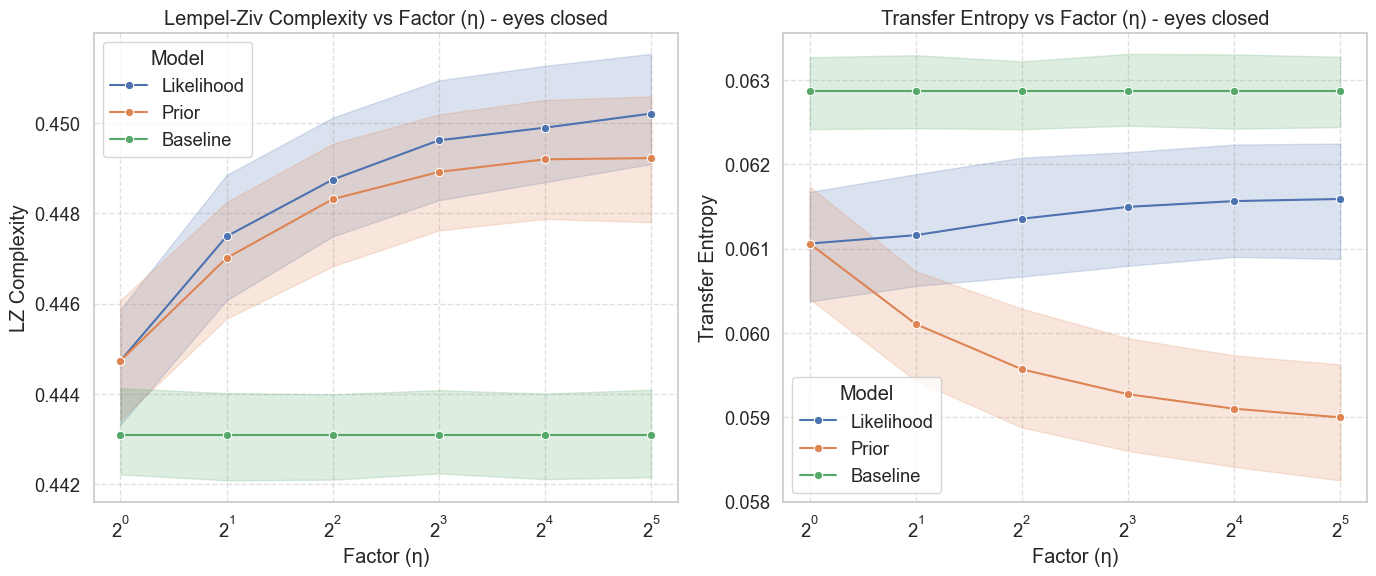

In [ ]:
plot_df(df_single_open, 'open')
plot_df(df_single_closed, 'closed')

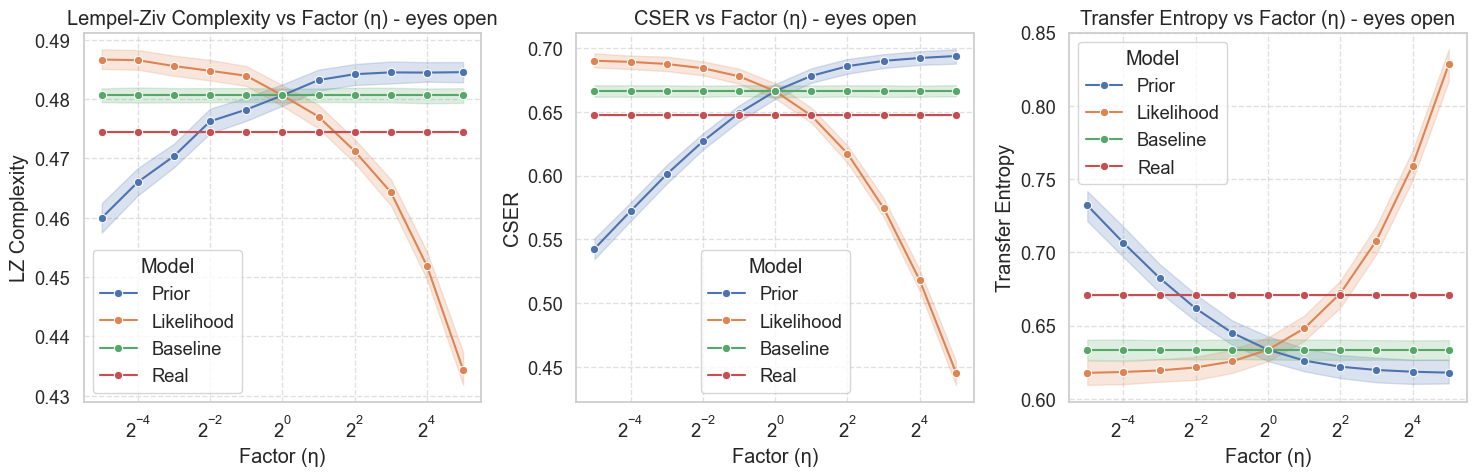

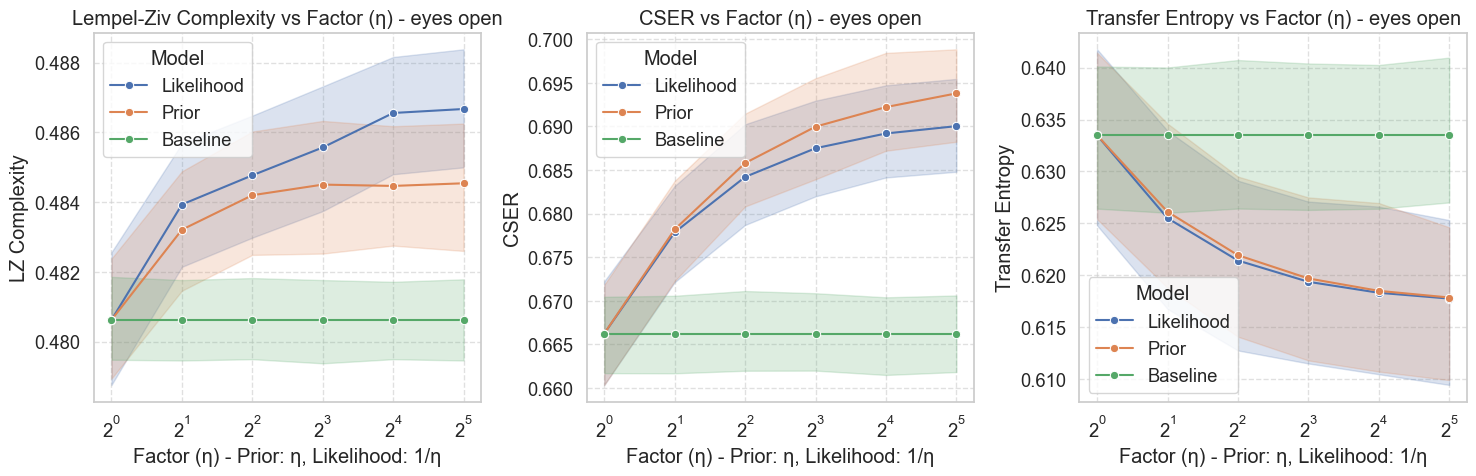

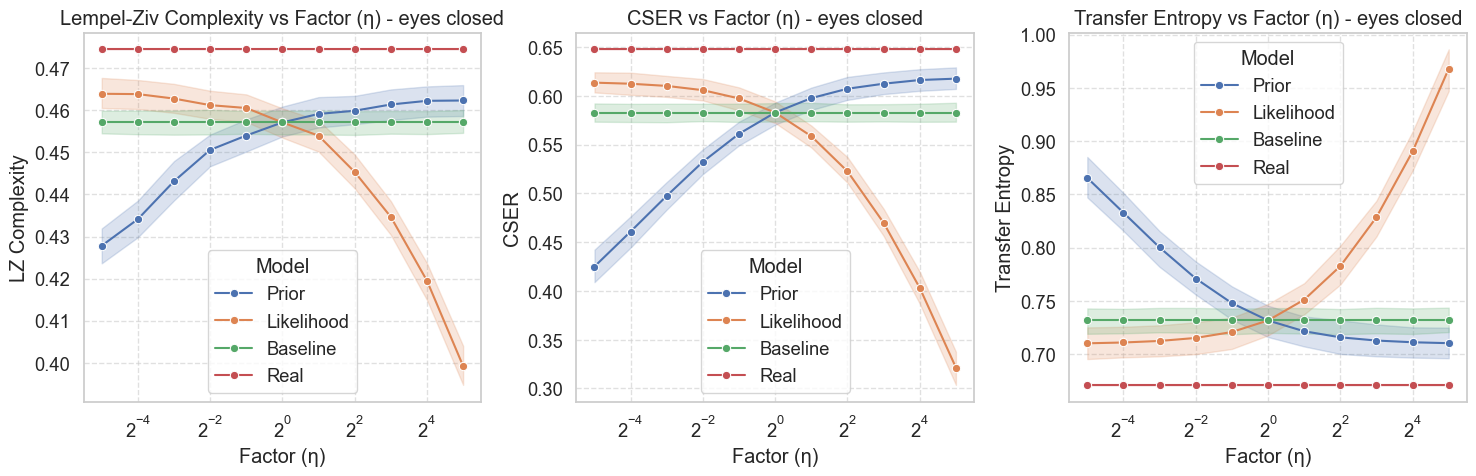

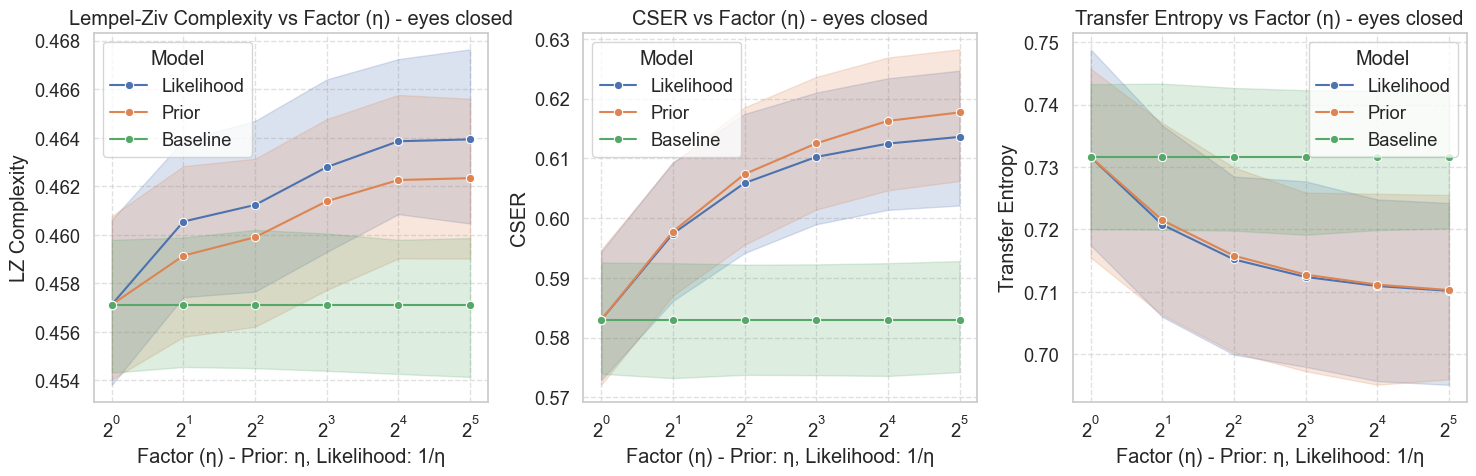

In [104]:
# Merge df_open_test with df_open_depressed_baseline
df_open_test_merge = pd.concat([df_open_test, df_open_depressed_baseline], ignore_index=True)

# Similarly for closed eyes
df_closed_test_merge = pd.concat([df_closed_test, df_open_depressed_baseline], ignore_index=True)

plot_df(df_open_test_merge, 'open')
plot_df(df_closed_test_merge, 'closed')

In [ ]:
def print_results(df):
    # df['Factor'] = df['Prior Factor'].fillna(df['Likelihood Factor'])

    # Calculate mean LZ and TE for each Model and Factor combination
    df_summary = df.groupby(['Model', 'Factor']).agg({
        'LZ': 'mean',
        'CSER': 'mean',
        'TE': 'mean'
    }).reset_index()

    print(f"\nBaseline Model:")
    baseline = df_summary[df_summary['Model'] == 'Baseline'].iloc[0]
    print(f"  Factor {baseline['Factor']:8.5f}: LZ = {baseline['LZ']:.6f}, CSER = {baseline['CSER']:.6f}, TE = {baseline['TE']:.6f}")

    # Print the results
    for model in ['Likelihood', 'Prior']:
        print(f"\n{model} Model:")
        model_data = df_summary[df_summary['Model'] == model]
        for _, row in model_data.iterrows():
            print(f"  Factor {row['Factor']:8.5f}: LZ = {row['LZ']:.6f}, CSER = {baseline['CSER']:.6f}, TE = {row['TE']:.6f}")


print("\n--- OPEN EYES ---")
print_results(df_open_test)
print("\n--- CLOSED EYES ---")
print_results(df_closed_test)


--- OPEN EYES ---

Baseline Model:
  Factor  0.03125: LZ = 0.480624, CSER = 0.666239, TE = 0.633485

Likelihood Model:
  Factor  0.03125: LZ = 0.486669, CSER = 0.666239, TE = 0.617738
  Factor  0.06250: LZ = 0.486555, CSER = 0.666239, TE = 0.618298
  Factor  0.12500: LZ = 0.485566, CSER = 0.666239, TE = 0.619358
  Factor  0.25000: LZ = 0.484768, CSER = 0.666239, TE = 0.621408
  Factor  0.50000: LZ = 0.483932, CSER = 0.666239, TE = 0.625492
  Factor  1.00000: LZ = 0.480624, CSER = 0.666239, TE = 0.633485
  Factor  2.00000: LZ = 0.477050, CSER = 0.666239, TE = 0.648007
  Factor  4.00000: LZ = 0.471233, CSER = 0.666239, TE = 0.671924
  Factor  8.00000: LZ = 0.464313, CSER = 0.666239, TE = 0.708026
  Factor 16.00000: LZ = 0.451880, CSER = 0.666239, TE = 0.759268
  Factor 32.00000: LZ = 0.434390, CSER = 0.666239, TE = 0.828362

Prior Model:
  Factor  0.03125: LZ = 0.459978, CSER = 0.666239, TE = 0.732085
  Factor  0.06250: LZ = 0.466024, CSER = 0.666239, TE = 0.706485
  Factor  0.12500: LZ